In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
import opendatasets as od
import os 
import shutil
import torch
import torchvision.transforms as tt
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as td
import random, time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
dataset_url = 'https://www.kaggle.com/grassknoted/asl-alphabet'

In [ ]:
if os.path.exists('./asl-alphabet'):
  shutil.rmtree('./asl-alphabet')

In [ ]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nithyashreem
Your Kaggle Key: ··········


100%|██████████| 1.03G/1.03G [00:21<00:00, 50.4MB/s]


In [ ]:
data_directory = './asl-alphabet/asl_alphabet_train/asl_alphabet_train'

In [ ]:
os.listdir(data_directory)

['K',
 'Q',
 'J',
 'H',
 'del',
 'P',
 'I',
 'L',
 'space',
 'nothing',
 'E',
 'O',
 'V',
 'D',
 'S',
 'Y',
 'T',
 'Z',
 'M',
 'C',
 'F',
 'B',
 'X',
 'G',
 'N',
 'W',
 'R',
 'A',
 'U']

In [ ]:
# train_data = ImageFolder(data_directory)

In [ ]:
train_data = ImageFolder(data_directory, tt.Compose([tt.Resize(128),
                                            tt.RandomCrop(128),
                                            tt.Grayscale(1),
                                            tt.ToTensor()]))

In [ ]:
len(train_data)

87000

In [ ]:
train_set_size = int(len(train_data) * 0.8)
valid_set_size = len(train_data) - train_set_size

In [ ]:
train_data, val_data = random_split(train_data, [train_set_size, valid_set_size])
len(train_data), len(val_data)

(69600, 17400)

In [ ]:
batch_size = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# PyTorch data loaders
# train = DataLoader(train_data, batch_size, shuffle=True)
# val = DataLoader(val_data, batch_size*2)

classes = ('A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','space','del','nothing')

In [ ]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.h1 = nn.Linear(1 * 128 * 128, 64) 
#         self.h2 = nn.Linear(64, 128)  
#         self.output = nn.Linear(128, 29)  
#         self.dropout = nn.Dropout(0.3) 

#     def forward(self, x):
#         x = x.view(-1, 1 * 128 * 128)
#         x = F.relu(self.h1(x))
#         x = F.relu(self.h2(x))
#         x = self.dropout(self.output(x))

#         return x

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_block(1, 64) 
        self.conv2 = conv_block(64, 128, pool=True) 
        self.res1 = nn.Sequential(conv_block(128, 128),  
                                  conv_block(128, 128))  
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), 
                                  conv_block(512, 512)) 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, 29))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
num_epochs = 10

net = ResNet9()
net.to(device)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.1, verbose=True, cooldown=10)

In [ ]:
max_accuracy = 0
train_losses = []
val_losses = []
acc_values=[]
val_accs=[]
for epoch in tqdm(range(num_epochs)):
    correct = 0
    correct_val=0
    start_time = time.time()
    train_loss = 0.0
    valid_loss = 0.0 
    
    for i, data in enumerate(train, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() 
        predictions = torch.max(outputs,1)[1]
        correct+=(predictions==labels).sum().cpu().numpy()

    with torch.no_grad():
        for i, data in enumerate(val, 0):
            val_inputs, val_labels = data
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            net.eval()
            val_preds = net(val_inputs)
            loss = criterion(val_preds, val_labels)
            valid_loss += loss.item()
            val_predictions = torch.max(val_preds, 1)[1]
            correct_val+=(val_predictions==val_labels).sum().cpu().numpy()

    acc = 100*correct/len(train.dataset)
    acc_values.append(acc)

    val_acc = 100*correct_val/len(val.dataset)
    val_accs.append(val_acc)

    train_losses.append(train_loss/len(train.dataset))
    val_losses.append(valid_loss/ len(val.dataset))

    print('Epoch %s , Training acc: %f, Validation acc: %f' %(epoch+1, acc, val_acc))

 10%|█         | 1/10 [10:24<1:33:37, 624.13s/it]

Epoch 1 , Training acc: 76.932471, Validation acc: 99.678161


 20%|██        | 2/10 [20:13<1:20:27, 603.49s/it]

Epoch 2 , Training acc: 73.087644, Validation acc: 99.379310


 30%|███       | 3/10 [30:02<1:09:38, 596.86s/it]

Epoch 3 , Training acc: 99.021552, Validation acc: 99.787356


 40%|████      | 4/10 [39:51<59:22, 593.82s/it]  

Epoch 4 , Training acc: 99.448276, Validation acc: 99.683908


 50%|█████     | 5/10 [49:40<49:21, 592.28s/it]

Epoch 5 , Training acc: 99.481322, Validation acc: 99.517241


 60%|██████    | 6/10 [59:31<39:27, 591.89s/it]

Epoch 6 , Training acc: 99.574713, Validation acc: 98.413793


 70%|███████   | 7/10 [1:09:24<29:36, 592.26s/it]

Epoch 7 , Training acc: 99.525862, Validation acc: 99.902299


 80%|████████  | 8/10 [1:19:20<19:46, 593.18s/it]

Epoch 8 , Training acc: 99.683908, Validation acc: 99.942529


 90%|█████████ | 9/10 [1:29:15<09:53, 593.90s/it]

Epoch 9 , Training acc: 99.750000, Validation acc: 99.816092


100%|██████████| 10/10 [1:39:10<00:00, 595.06s/it]

Epoch 10 , Training acc: 99.715517, Validation acc: 99.798851


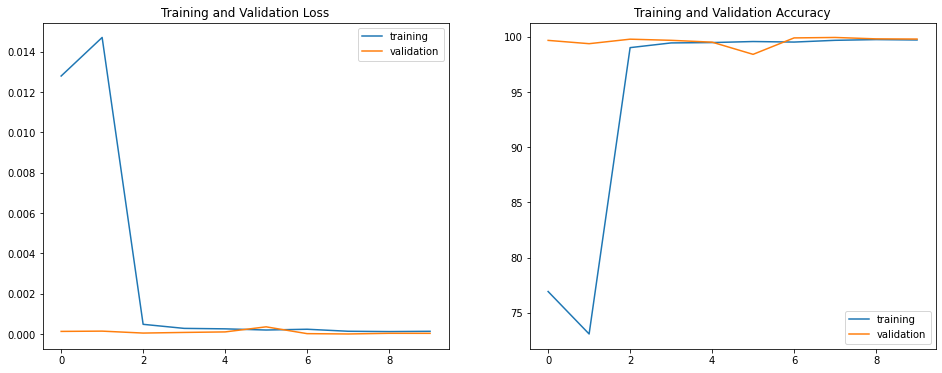

In [ ]:
fig, _ = plt.subplots(1, 2)
fig.set_size_inches(16, 6)

fig.axes[0].plot(train_losses, label="training")
fig.axes[0].plot(val_losses, label="validation")
fig.axes[0].set_title("Training and Validation Loss")
fig.axes[0].legend()
fig.axes[1].plot(acc_values, label="training")
fig.axes[1].plot(val_accs, label="validation")
fig.axes[1].set_title("Training and Validation Accuracy")
fig.axes[1].legend()

In [ ]:
torch.save(net.state_dict(), 'linear.pth')

In [ ]:
import shutil
import os

In [ ]:
train_dir = "/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
test_dir = "/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test_reorg"

if not os.path.exists(test_dir):
  os.makedirs(test_dir)

In [ ]:
old_train_dir = "/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test"

for img in os.listdir(old_train_dir):
  if not img.endswith("jpg"):
    continue

  cl = img.split('_')[0]
  
  shutil.copy(
      os.path.join(old_train_dir, img),
      os.path.join(test_dir, cl, img)
      )

In [ ]:
test_classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

for cl in test_classes:
  os.makedirs(os.path.join(test_dir, cl))

In [ ]:
shutil.copy("/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/del/del1.jpg",
            "/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test_reorg/del"
            )

'/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test_reorg/del/del1.jpg'

In [ ]:
data_dir = '/content/asl-alphabet/asl_alphabet_test'
test_data = ImageFolder("/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test_reorg", tt.Compose([tt.Resize(128),
                                            tt.RandomCrop(128),
                                            tt.Grayscale(1),
                                            tt.ToTensor()]))
test = DataLoader(test_data)
correct=[]
wrong=[]
with torch.no_grad():
  correct_val=0
  for i, data in enumerate(test, 0):
    test_inputs, test_labels = data
    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
    net.eval()
    test_preds = net(test_inputs)
    test_predictions = torch.max(test_preds, 1)[1]
    correct_val+=(test_predictions==test_labels).sum().cpu().numpy()
    if test_predictions==test_labels:
      correct.append(i)
    else:
      wrong.append(i)

print("The test accuracy over %s samples is %f" %(len(test), correct_val/len(test.dataset)*100))

The test accuracy over 29 samples is 100.000000


In [ ]:
test_predictions

tensor([28], device='cuda:0')

In [ ]:
torch.save(net.state_dict(), 'resnet.pth')

In [ ]:
net = ResNet9()
net.load_state_dict(torch.load("/content/resnet.pth"))
net.cuda()
net.eval()

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr